In [57]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [58]:
time_start = time.time()

In [59]:
w = WifiPipeline()

In [60]:
# Uncomment when new traffic is collected. Keep commented otherwise to prevent overwriting current csv files
# w.extract_packet_features(create_master=True)

In [61]:
df = w.make_dataframe()

# Take out packets from router
df = df[df["DeviceType"]!="router"]

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Data Exploration

In [62]:
sns.set_palette(sns.color_palette("GnBu_d"))

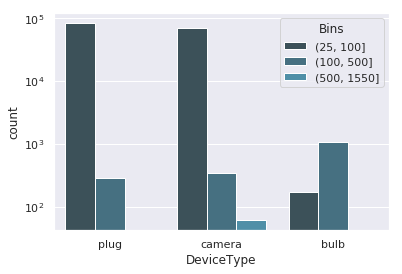

In [63]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['PacketLength'], bins=[25,100,500,1550]));
g.set_yscale('log')
plt.legend(title='Bins', loc='upper_right');
plt.savefig('Results/Plots/wifi-packetlength.png', bbox_inches='tight')

Belkin     93477
Dropcam    45912
Tp-link    17713
Lifi        1040
Name: Vendor, dtype: int64


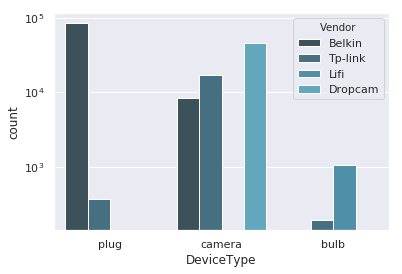

In [64]:
g = sns.countplot(x=df["DeviceType"], hue=df["Vendor"]);
g.set_yscale('log')
print df['Vendor'].value_counts()
plt.savefig('Results/Plots/wifi-vendor.png', bbox_inches='tight')

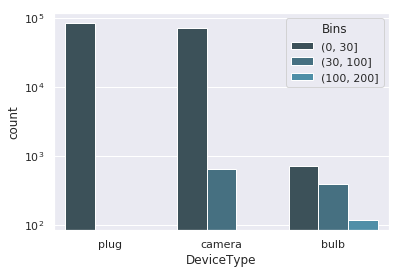

In [65]:
g = sns.countplot(x=df['DeviceType'], hue=pd.cut(df['Assoc_Packets'], bins=[0,30,100,200]));
g.set_yscale('log')
plt.legend(title='Bins', loc='upper_right');
plt.savefig('Results/Plots/wifi-assocpackets.png', bbox_inches='tight')

QoS_Null    132500
QoS_Data     20539
Data          5103
Name: Subtype, dtype: int64


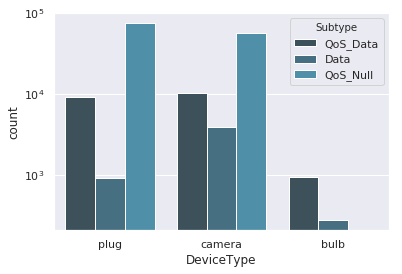

In [66]:
g = sns.countplot(x=df["DeviceType"], hue=df["Subtype"]);
g.set_yscale('log')
print df['Subtype'].value_counts()
plt.savefig('Results/Plots/wifi-subtype.png', bbox_inches='tight')

## Resample

### Downsampling

In [67]:
df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [68]:
df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

### Create downsampled trial dataframes

In [69]:
df_trials = []
num_trials = 25
for i in range(0,num_trials):
    # Down
    df_downsampled = w.downsample(X, y, df[df["Set"]=="test"])
    df_trials.append(df_downsampled)

In [70]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

# Run trials

In [71]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = w.one_vs_all_classify(trial, features_list, y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25


## Reports/Plots

### AUC

In [72]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []

for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()

    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']
            
            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)            
            
            # Plot ROC curve
#             fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
#             auc = roc_auc_score(true, pred_proba[:,1])
#             title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
#             skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
#                                    classes_to_plot=[1], figsize=(8,6));

### Print csv results

In [73]:
df_alloutput = w.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/wifi-alltrials.csv', mode='w')

In [74]:
cm_metrics = ['TP','FP','FN','TN']
performance_metrics = ['Accuracy', 'Precision','Recall','AUC']

df_meancm = pd.DataFrame(columns= w.get_header(cm_metrics))
df_meanmetrics = pd.DataFrame(columns= w.get_header(performance_metrics))

devalg_combinations = [(x,y) for x in df_alloutput['Device'].unique() for y in df_alloutput['Classifier'].unique()]
for x in devalg_combinations:    
    # Report mean confusion matrix
    cm = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), cm_metrics]
    mean_cm = w.get_mean_metric(cm, cm_metrics)
    mean_cm_series = pd.Series(data=mean_cm, name=str(x), index=df_meancm.columns)
    df_meancm = df_meancm.append(mean_cm_series)
    
    # Report mean performance metrics
    metrics = df_alloutput.loc[(df_alloutput['Device']==x[0]) & (df_alloutput['Classifier']==x[1]), performance_metrics]
    mean_metrics = w.get_mean_metric(metrics, performance_metrics)
    mean_metrics_series = pd.Series(data=mean_metrics, name=str(x), index=df_meanmetrics.columns)
    df_meanmetrics = df_meanmetrics.append(mean_metrics_series)

# Print out to csv    
df_meancm.to_csv('Results/wifi-meanCM.csv', mode='w')
df_meanmetrics.to_csv('Results/wifi-meanmetrics.csv', mode='w')

In [75]:
df_performance_device = w.report_metrics_across('Device', df_alloutput)
df_performance_device.to_csv('Results/wifi-devtype.csv', mode='w')

In [76]:
df_performance_classifier = w.report_metrics_across('Classifier', df_alloutput)
df_performance_classifier.to_csv('Results/wifi-classifier.csv', mode='w')

In [77]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### Time Performance

In [78]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in device_types:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 3.10416603088 seconds
(Bulb, KNN) : 0.708188056946 seconds
(Bulb, LDA) : 0.00996613502502 seconds
(Bulb, RF) : 0.0671529769897 seconds
(Camera, KNN) : 0.707355976105 seconds
(Camera, LDA) : 0.0102739334106 seconds
(Camera, RF) : 0.0825672149658 seconds
(Plug, KNN) : 0.707649946213 seconds
(Plug, LDA) : 0.010143995285 seconds
(Plug, RF) : 0.0675950050354 seconds

Trial  1
Total time: 2.90127801895 seconds
(Bulb, KNN) : 0.648292064667 seconds
(Bulb, LDA) : 0.0102450847626 seconds
(Bulb, RF) : 0.0675759315491 seconds
(Camera, KNN) : 0.640057086945 seconds
(Camera, LDA) : 0.00981998443604 seconds
(Camera, RF) : 0.0720520019531 seconds
(Plug, KNN) : 0.644286155701 seconds
(Plug, LDA) : 0.0102541446686 seconds
(Plug, RF) : 0.0707561969757 seconds

Trial  2
Total time: 3.08278393745 seconds
(Bulb, KNN) : 0.707193851471 seconds
(Bulb, LDA) : 0.0101838111877 seconds
(Bulb, RF) : 0.06618309021 seconds
(Camera, KNN) : 0.704069852829 seconds
(Camera, LDA) : 0.0104088783264 sec

### Feature Importance

In [79]:
# Extract feature importance values
df_featImp = pd.DataFrame()
for i,f in enumerate(w.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [80]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [81]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
feat_imp.to_csv('Results/wifi-feature_importance.csv', mode='w')

### Sampling Counts

In [82]:
print "Packet Counts Prior to Resampling"
dt_vc = df["DeviceType"].value_counts()
print dt_vc

Packet Counts Prior to Resampling
plug      85512
camera    71399
bulb       1231
Name: DeviceType, dtype: int64


Training Set plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

Test Set camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


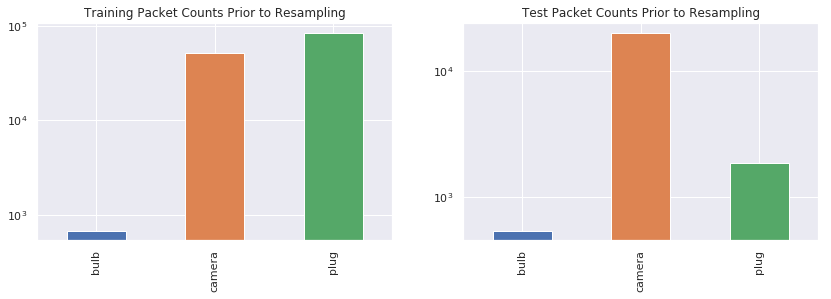

In [83]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling", logy=True);
print "Training Set", df_train["DeviceType"].value_counts()
print

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling", logy=True);
print "Test Set", df_test["DeviceType"].value_counts()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


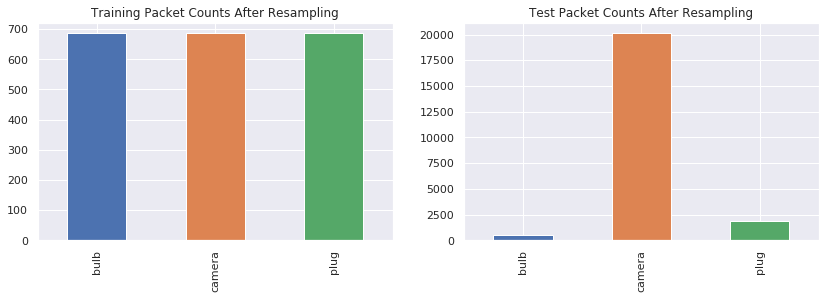

In [84]:
# Plot post-sampling
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
